<a href="https://colab.research.google.com/github/dainilliniad/small311qlab/blob/generation/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#выгрузка необходимых библиотек
import math
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from torch import unsqueeze as unsQ
import time
import tqdm
from tqdm import tqdm

In [ ]:
#создание оригинала изображения, тетта от -e/2 до e/2
def onePatOfObject(x, y, pmax = 0.9): #degree  радианах, идеальность от 0 до 1, pmin неидеальности диапазоны
    p=torch.rand(x, y)*pmax
    tetta=torch.rand(x,y)*2.72-1.36*torch.ones([x,y])   #диапазон от -e/2 до e/2
    return torch.tensor(p),torch.tensor(tetta)


#создание одного шаблона освещения
def createRandomPattern(width, height, seed = np.nan, device = 'cpu'):
  if not(np.isnan(seed)) : torch.manual_seed(seed)
  return torch.randint(low = 0, high = 2, size = (width, height), device = device,dtype = torch.float)
  #return torch.rand(width, height)

#одного измерение сигнала после объекта
def createObjectSignal(pattern,objectProfile, device = 'cpu'):
  return unsQ(torch.sum(torch.mul(objectProfile, pattern)),0)

# создание последовательности симулированных данных для объекта
def createEmulData(numbOfMeasur, objectProfile, device = 'cpu'):
  width = objectProfile.size()[0]
  height = objectProfile.size()[1]
  patterns = unsQ(createRandomPattern(width, height, device = device),0)
  objData = createObjectSignal(patterns[0],objectProfile, device = device)
  for num in range(1,numbOfMeasur):
    localPat = createRandomPattern(width, height, device = device)
    objData = torch.cat((objData,createObjectSignal(localPat,objectProfile, device = device)),0)
    patterns = torch.cat((patterns,unsQ(localPat,0)),0)
  return patterns, objData

def crossCorrelation(patterns, objData, device = 'cpu'): #подсчет корреляционной функции
  localLen = objData.shape[0]
  correlation = torch.zeros_like(patterns[0])
  for i in range(localLen):
    correlation += (patterns[i]*objData[i])
  correlation/= localLen
  return (correlation - torch.mean(patterns,0)*torch.mean(objData))
def dispersion(patterns):  #подсчет дисперсии
  return torch.mean((patterns*patterns), 0) - torch.mean(patterns,0)*torch.mean(patterns,0)

In [ ]:
#cpu or gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
#задание настраиваемых параметров:
x, y = 7, 7 # размеры картинки
pmax1=0.9 #максимальное значение величины анизотропии p
num_frames=10000 #число шаблонов освещения для приближения корреляционой функции
num_objs=300 #число объектов

In [ ]:
##создание выборки##
pitog=[]
tetitog=[]
cor1=[]
cor2=[]
cor3=[]
for i in tqdm(range(num_objs)):
  obj=onePatOfObject(x, y, pmax = pmax1)
  p, tet=obj[0], obj[1]
  T0=torch.cos(tet)*torch.cos(tet)+p*p*torch.sin(tet)*torch.sin(tet)
  T22=1/2*(1+p*p+(1-p*p)*torch.sin(2*tet))
  T45=torch.sin(tet)*torch.sin(tet)+p*p*torch.cos(tet)*torch.cos(tet)
  pat_test,objData_test = createEmulData(num_frames,T0,device = device)
  correlation1 = crossCorrelation(pat_test,objData_test,device = device)
  pat_test,objData_test = createEmulData(num_frames,T22,device = device)
  correlation2 = crossCorrelation(pat_test,objData_test,device = device)
  pat_test,objData_test = createEmulData(num_frames,T45,device = device)
  correlation3 = crossCorrelation(pat_test,objData_test,device = device)


  for j in range(7):
    for k in range(7):
      pitog.append(float(p[j][k]))
      tetitog.append(float(tet[j][k]))
      cor1.append(float(correlation1[j][k]))
      cor2.append(float(correlation2[j][k]))
      cor3.append(float(correlation3[j][k]))
np.save('pitog', pitog)
np.save('tetitog', tetitog)
np.save('cor1', cor1)
np.save('cor2', cor2)
np.save('cor3', cor3)

In [7]:
#создание наглядных распределений p и тетта
pkras=[[0.0, 0.14, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.14, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.14, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.14, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.14, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.166, 0.28, 0.42, 0.56, 0.70, 0.84],
       [0.0, 0.166, 0.28, 0.42, 0.56, 0.70, 0.84]]

tetkras=[[-1.36, -1.36, -1.36, -1.36, -1.36, -1.36, -1.36],
        [-0.91, -0.91, -0.91, -0.91, -0.91, -0.91, -0.91],
        [-0.46, -0.46, -0.46, -0.46,  -0.46, -0.46, -0.46],
        [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
        [0.44, 0.44, 0.44, 0.44,  0.44, 0.44, 0.44],
        [0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89],
        [1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34]]


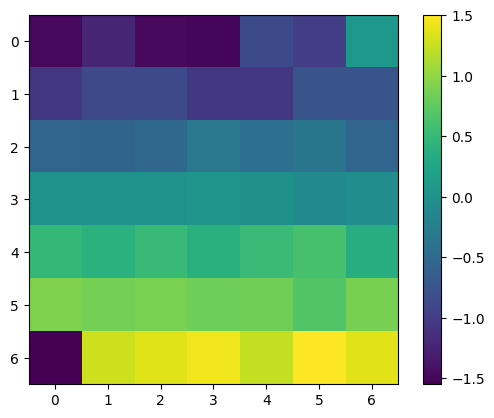

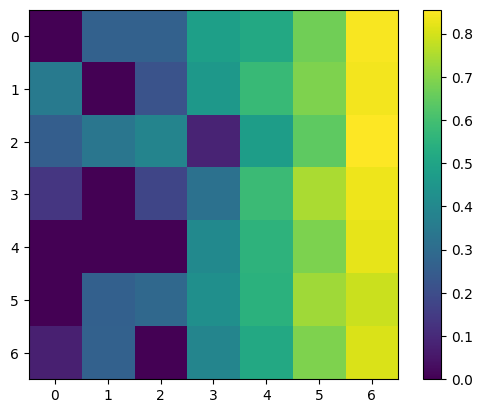

tensor([[1.3803e-03, 3.4854e-02, 2.3599e-02, 6.0452e-02, 8.2253e-02, 1.2849e-01,
         1.7494e-01],
        [1.0877e-01, 9.0632e-02, 1.0389e-01, 1.2040e-01, 1.3158e-01, 1.6663e-01,
         2.0724e-01],
        [2.0276e-01, 2.1044e-01, 2.0882e-01, 1.8549e-01, 1.9987e-01, 2.1685e-01,
         2.2721e-01],
        [2.6531e-01, 2.4832e-01, 2.4718e-01, 2.4387e-01, 2.3789e-01, 2.6675e-01,
         2.5079e-01],
        [1.9386e-01, 2.0227e-01, 1.8930e-01, 2.1148e-01, 2.1028e-01, 2.2202e-01,
         2.3339e-01],
        [8.4193e-02, 1.2092e-01, 1.1833e-01, 1.3548e-01, 1.4682e-01, 1.8468e-01,
         1.9873e-01],
        [2.4223e-04, 3.3366e-02, 1.1453e-02, 4.4728e-02, 8.6828e-02, 1.2093e-01,
         1.7143e-01]])
tensor([[0.0675, 0.0850, 0.0719, 0.1211, 0.1401, 0.1548, 0.2144],
        [0.0034, 0.0033, 0.0230, 0.0309, 0.0808, 0.1407, 0.1846],
        [0.0190, 0.0222, 0.0438, 0.0633, 0.0860, 0.1341, 0.1891],
        [0.1328, 0.1275, 0.1320, 0.1522, 0.1644, 0.1832, 0.2077],
        [0.231

In [37]:
p, tet=torch.tensor(pkras), torch.tensor(tetkras)
#print(p)
#print(tet)
T0=torch.cos(tet)**2+(p*torch.sin(tet))**2
T22=1/2*(1+p*p+(1-p*p)*torch.sin(2*tet))
T45=torch.sin(tet)**2+(p*torch.cos(tet))**2
pat_test,objData_test = createEmulData(10000,T0,device = device)
correlation1 = crossCorrelation(pat_test,objData_test,device = device)/dispersion(pat_test)
pat_test,objData_test = createEmulData(10000,T22,device = device)
correlation2 = crossCorrelation(pat_test,objData_test,device = device)/dispersion(pat_test)
pat_test,objData_test = createEmulData(10000,T45,device = device)
correlation3 = crossCorrelation(pat_test,objData_test,device = device)/dispersion(pat_test)

p_guess=correlation1+correlation3-1
p_guess[p_guess<0]=0
p_guess=torch.sqrt(p_guess)
p_guess[p_guess>0.9]=0.9

tet_guess=(2*correlation2-1-p_guess*p_guess)/((1-p_guess*p_guess+correlation1-correlation3))
tet_guess=torch.atan(tet_guess)

plt.imshow(tet_guess.to('cpu'))
plt.colorbar()
plt.show()
plt.imshow(p_guess)
plt.colorbar()
plt.show()

#
print(correlation1/4)
print(correlation2/4)
print(correlation3/4)

In [21]:
print(p_guess)
print(tet_guess)  #вывод аналитических p и tetta

tensor([[0.0000, 0.2072, 0.2287, 0.4488, 0.5923, 0.7234, 0.8564],
        [0.1744, 0.0000, 0.3940, 0.4763, 0.5313, 0.7104, 0.7943],
        [0.0000, 0.0000, 0.3873, 0.3282, 0.5043, 0.6831, 0.8110],
        [0.0000, 0.1866, 0.0744, 0.4463, 0.4768, 0.6676, 0.7683],
        [0.2674, 0.0000, 0.0000, 0.4109, 0.6263, 0.6931, 0.8677],
        [0.1730, 0.0000, 0.3584, 0.4388, 0.5302, 0.7566, 0.8531],
        [0.0000, 0.3140, 0.4079, 0.4945, 0.5263, 0.7932, 0.8832]])
tensor([[-1.2280, -1.4406, -1.0884, -1.3389,  1.3360, -0.9507, -0.4735],
        [-0.9209, -0.8469, -0.9794, -1.0002, -0.7890, -0.8275, -0.8655],
        [-0.4264, -0.4533, -0.4450, -0.3161, -0.3741, -0.5613, -0.3376],
        [-0.0255, -0.0756,  0.0280, -0.0082,  0.0689,  0.1296,  0.4653],
        [ 0.5580,  0.4336,  0.5841,  0.4274,  0.4489,  0.5154, -0.0198],
        [ 0.9037,  0.8240,  0.8180,  0.8963,  0.9752,  1.0526,  1.1587],
        [ 1.5082, -1.3233, -1.5427,  1.5606,  1.1332,  1.4245, -1.1768]])


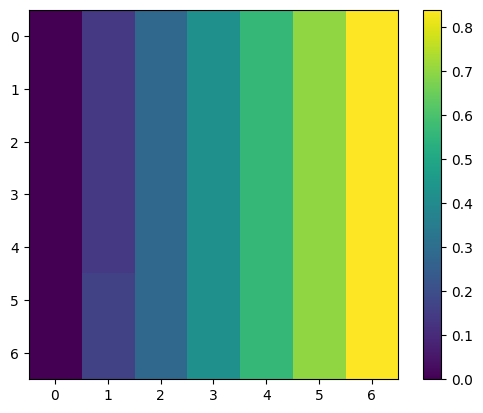

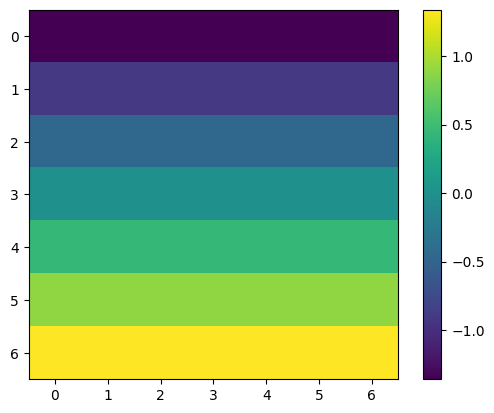

In [26]:
plt.imshow(p)
plt.colorbar()
plt.show()

plt.imshow(tet)

plt.colorbar()
plt.show()

In [27]:
#подсчет ошибки, тензоры с результатами сети и аналитического счета
p_neuro=torch.tensor([[0.1778, 0.1800, 0.2819, 0.4878, 0.6169, 0.8181, 0.9363],
        [0.1973, 0.1859, 0.3693, 0.4496, 0.6314, 0.7893, 0.8884],
        [0.1900, 0.1672, 0.4060, 0.4916, 0.5937, 0.7393, 0.9214],
        [0.1844, 0.2376, 0.2133, 0.4802, 0.5285, 0.6908, 0.8402],
        [0.2496, 0.1897, 0.1926, 0.4326, 0.6463, 0.7436, 0.9467],
        [0.2315, 0.1765, 0.3467, 0.4747, 0.5809, 0.8561, 0.9316],
        [0.1566, 0.2408, 0.4042, 0.5195, 0.5937, 0.8897, 0.9423]])
tet_neuro=torch.tensor([[0.0569, 0.0537, 0.0627, 0.0639, 0.0790, 0.0894, 0.1956],
        [0.1924, 0.1949, 0.1708, 0.1750, 0.1435, 0.1855, 0.1454],
        [0.3620, 0.3564, 0.3482, 0.3269, 0.3384, 0.3149, 0.2728],
        [0.4985, 0.4796, 0.5117, 0.5143, 0.5265, 0.5488, 0.6311],
        [0.6701, 0.6566, 0.6906, 0.6426, 0.6308, 0.6462, 0.4143],
        [0.7811, 0.7656, 0.7939, 0.8150, 0.8238, 0.8408, 0.8483],
        [0.9227, 0.9212, 0.9223, 0.9216, 0.9106, 0.1485, 0.8987]])
p_analitic=torch.tensor([[0.0000, 0.2072, 0.2287, 0.4488, 0.5923, 0.7234, 0.8564],
        [0.1744, 0.0000, 0.3940, 0.4763, 0.5313, 0.7104, 0.7943],
        [0.0000, 0.0000, 0.3873, 0.3282, 0.5043, 0.6831, 0.8110],
        [0.0000, 0.1866, 0.0744, 0.4463, 0.4768, 0.6676, 0.7683],
        [0.2674, 0.0000, 0.0000, 0.4109, 0.6263, 0.6931, 0.8677],
        [0.1730, 0.0000, 0.3584, 0.4388, 0.5302, 0.7566, 0.8531],
        [0.0000, 0.3140, 0.4079, 0.4945, 0.5263, 0.7932, 0.8832]])
tet_analitic=torch.tensor([[-1.2280, -1.4406, -1.0884, -1.3389,  1.3360, -0.9507, -0.4735],
        [-0.9209, -0.8469, -0.9794, -1.0002, -0.7890, -0.8275, -0.8655],
        [-0.4264, -0.4533, -0.4450, -0.3161, -0.3741, -0.5613, -0.3376],
        [-0.0255, -0.0756,  0.0280, -0.0082,  0.0689,  0.1296,  0.4653],
        [ 0.5580,  0.4336,  0.5841,  0.4274,  0.4489,  0.5154, -0.0198],
        [ 0.9037,  0.8240,  0.8180,  0.8963,  0.9752,  1.0526,  1.1587],
        [ 1.5082, -1.3233, -1.5427,  1.5606,  1.1332,  1.4245, -1.1768]])

In [29]:
#подсчет ошибки
n=49
mae_analitic_p=(torch.sum(torch.abs(p_analitic-p)))/(n*0.9)  #0.9 - разброс p
mae_neuro_p=(torch.sum(torch.abs(p_neuro-p)))/(n*0.9)
print('Модуль средней ошибки аналитического счета P:')
print(mae_analitic_p)
print('Модуль средней ошибки нейронного счета P:')
print((mae_neuro_p))
mae_analitic_tet=(torch.sum(torch.abs(tet_analitic-tet)))/(n*np.pi)  #np.pi() - разброс p
mae_neuro_tet=(torch.sum(torch.abs(tet_neuro-tet)))/(n*np.pi)
print('Модуль средней ошибки аналитического счета tetta:')
print(mae_analitic_tet)
print('Модуль средней ошибки нейронного счета tetta:')
print(mae_neuro_tet)

Модуль средней ошибки аналитического счета P:
tensor(0.0805)
Модуль средней ошибки нейронного счета P:
tensor(0.0952)
Модуль средней ошибки аналитического счета tetta:
tensor(0.1075)
Модуль средней ошибки нейронного счета tetta:
tensor(0.2120)
